# Generate the Quantum distribution

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$


### States:
$$\ket{\psi} = \lambda_0\ket{01} + \lambda_1\ket{10}$$


### Measurnments:

\begin{split}
    \ket{\phi_{1,0}} &= u \ket{0,1} + v\ket{1,0}\\
    \ket{\phi_{1,1}} &= v \ket{0,1} - u\ket{1,0}\\
    \ket{\phi_{0,0}} &= w \ket{0,0} + z\ket{1,1}\\
    \ket{\phi_{0,1}} &= z \ket{0,0} - w\ket{1,1}
\end{split}

In [1]:
import numpy as np
from numpy import kron
import math
from math import sqrt
from random import random
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from itertools import product
from matplotlib import colors
import time

def new_index(x):   # 012345 --> 123450
    b  = bin(x)[2:].zfill(6) # x in binary b0..b5
    y = int(b[1:]+b[0], 2)
    return y



def change_qbit_order(x): # 012345 --> 123450  # for states
    x_ordered = np.zeros_like(x)
    for i in range(64):
        x_ordered[new_index(i)] = x[i]
    return x_ordered


def PP(w,z,u,v,lambda_0,lambda_1):
    
    ## settign states
    state_0 = np.array([1,0])
    state_1 = np.array([0,1])
    
    state_00 = kron(state_0,state_0)
    state_01 = kron(state_0,state_1)
    state_10 = kron(state_1,state_0)
    state_11 = kron(state_1,state_1)
    
    psi = (lambda_0*state_01 + lambda_1*state_10)
    
    total_psi = kron(kron(psi,psi),psi)
    total_psi_ordered = change_qbit_order(total_psi)
    
    
    
    
    # Setting Measurment 
    out_00 = z*state_00 + w*state_11
    out_01 = w*state_00 - z*state_11
    out_10 = u*state_01 + v*state_10
    out_11 = v*state_01 - u*state_10
    
    M_state = np.array([[out_00, out_01],[out_10, out_11]])
    
    ## Resulting distribution
    
    p = np.zeros((2,2,2,2,2,2))

    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
    
        total_M_state = kron(kron(M_state[a1,a2], M_state[b1,b2]), M_state[c1,c2])        
        p[a1,a2,b1,b2,c1,c2] = np.inner(total_M_state, total_psi_ordered)**2

    return p

# find epsilon...... it only depens on  V !!!





/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#%%
import sys
import mosek
import scipy.sparse as sp
# Since the value of infinity is ignored, we define it solely
# for symbolic purposes
inf = 1.0




# Define a stream printer to grab output from MOSEK
def streamprinter(text):
    sys.stdout.write(text)
    sys.stdout.flush()
    
def main_for_LP(c, A_eq, b_eq, verbose=False):
    # Create a task object

    A = sp.coo_matrix(A_eq)
    
    with mosek.Env() as env:
        with env.Task(0, 0) as task:
            # Attach a log stream printer to the task
            if verbose:
                task.set_Stream(mosek.streamtype.log, streamprinter)
    
            # Bound keys for constraints
            bkc = [mosek.boundkey.fx for i in range(len(A_eq))]
    
            # Bound values for constraints
            buc = list(b_eq)
            blc = list(b_eq)
            
            # Bound keys for variables
            bkx = [mosek.boundkey.ra for i in range(len(c))]
    
            # Bound values for variables
            blx = [0.0 for i in range(len(c))]
            bux = [1.0 for i in range(len(c))]
    
            numvar = len(bkx)
            numcon = len(bkc)

            # Append 'numcon' empty constraints.
            # The constraints will initially have no bounds.
            task.appendcons(numcon)
    
            # Append 'numvar' variables.
            # The variables will initially be fixed at zero (x=0).
            task.appendvars(numvar)
    
            for j in range(numvar):
                # Set the linear term c_j in the objective.
                task.putcj(j, c[j])
    
                # Set the bounds on variable j
                # blx[j] <= x_j <= bux[j]
                task.putvarbound(j, bkx[j], blx[j], bux[j])
    
                # Input column j of A
            task.putaijlist(list(A.row),list(A.col),list(A.data))          
    
            # Set the bounds on constraints.
             # blc[i] <= constraint_i <= buc[i]
            for i in range(numcon):
                task.putconbound(i, bkc[i], blc[i], buc[i])
    
            # Input the objective sense (minimize/maximize)
            task.putobjsense(mosek.objsense.minimize)
    
            # Solve the problem
            task.optimize()
            # Print a summary containing information
            # about the solution for debugging purposes
            if verbose:
                task.solutionsummary(mosek.streamtype.msg)
    
            # Get status information about the solution
            solsta = task.getsolsta(mosek.soltype.bas)
    
            #if (solsta == mosek.solsta.optimal):
            #xx = [0.0] * numvar
            #task.getxx(mosek.soltype.itr, xx)
                #print("Optimal solution: ")
                #for i in range(numvar):
                #    print("x[" + str(i) + "]=" + str(xx[i]))
            #elif (solsta == mosek.solsta.dual_infeas_cer or
            #      solsta == mosek.solsta.prim_infeas_cer):
            #    if verbose:
            #        print("Primal or dual infeasibility certificate found.\n")
            #elif solsta == mosek.solsta.unknown:
            #    print("Unknown solution status")
            #else:
            #    print("Other solution status")
            #obje = task.getprimalobj(mosek.soltype.itr)
            #if verbose:
            #    print(obje)
            return solsta

## The LP for noiseless case with P (a2, b2, c2 , ta, tb, tc) as variables

the variables are the elements of the probability distribution P (a2, b2, c2 , ta, tb, tc)  => 64 vars

\begin{align}
&P(a_1,a_2,b_1,b_2,c_1,c_2) = \sum_{t_a, t_b, t_c \Rightarrow a_1, b_1, c_1}{P(a_2,b_2,c_2, t_a, t_b, t_c)}\\
&P(a_2|0, t_b, t_c) = P(a_2|1, t_b, t_c) \Leftrightarrow q(t_a = 1) \sum_{b_2,c_2}  {P(a_2,b_2,c_2,0, t_b, t_c)} - q(t_a = 0) \sum_{b_2,c_2}P(a_2,b_2,c_2,1, t_b, t_c) = 0
\end{align}

In [3]:
def get_result_map_mosek(l0, N_it):   #l0 --> lambda0 

    l1 = np.sqrt(1-l0**2)
    
    q = l0**2  #probability of sending token to right/left?

    q_a = [q, 1-q]
    q_b = [q, 1-q]
    q_c = [q, 1-q]

    c = np.ones(64) 


    # Form the matrix A

    #First we consider the probability constraints 

    A_1 = np.zeros((64,64))

    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
        constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
        for ta,tb,tc in product(range(2), repeat=3): 
            if (a1 == (tb+tc+1)%2) and (b1 == (ta+tc+1)%2) and (c1 == (ta+tb+1)%2): # ParityCheck
                var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
                A_1[constraint_it, var_it] = 1



    #Now we consider the network independence constraints

    A_3a = np.zeros((8,64))
    for a2,tb,tc in product(range(2),repeat=3):
        constraint_it = np.inner([4,2,1],[a2,tb,tc])
        for b2,c2 in product(range(2),repeat=2):
            var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,0,tb,tc]) # ta = 0
            var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,1,tb,tc]) # ta = 1
            A_3a[constraint_it, var_it_0] = q_a[1]/q_a[0]
            A_3a[constraint_it, var_it_1] = -1


    A_3b = np.zeros((8,64))
    for b2,ta,tc in product(range(2),repeat=3):
        constraint_it = np.inner([4,2,1],[b2,ta,tc])
        for a2,c2 in product(range(2),repeat=2):
            var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,0,tc])# tb = 0
            var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,1,tc])# tb = 1
            A_3b[constraint_it, var_it_0] = q_b[1]/q_b[0]
            A_3b[constraint_it, var_it_1] = -1


    A_3c = np.zeros((8,64))
    for c2,ta,tb in product(range(2),repeat=3):
        constraint_it = np.inner([4,2,1],[c2,ta,tb])
        for a2,b2 in product(range(2),repeat=2):
            var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,0])# tc = 0
            var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,1])# tc = 1
            A_3c[constraint_it, var_it_0] = q_c[1]/q_c[0]
            A_3c[constraint_it, var_it_1] = -1




    A = np.concatenate([A_1,A_3a,A_3b,A_3c])  

    #remove the redundant rows
    #_, inds = sympy.Matrix(A).T.rref()   # I transposed to check for the rows 
    #A = A[np.array(inds)]
    #print("Number of independent equations", A.shape[0])

    #print("Size of The LP system: ", A.shape)



    N_it_u = N_it
    N_it_w = N_it//2

    phi_u_list = np.linspace(0, np.pi/2, num = N_it_u)
    phi_w_list = np.linspace(0, np.pi/4, num = N_it_w)  ## symmetry

    result_map = np.zeros((N_it_u, N_it_w)) 
    
    for i in range(N_it_u):
        for j in range(N_it_w):
            tic1 = time.perf_counter()
            phi_u = phi_u_list[i]
            phi_w = phi_w_list[j]
            
            prob = PP(np.cos(phi_w), np.sin(phi_w), np.cos(phi_u), np.sin(phi_u),l0,l1)


            # Form the vector b            
            b_1 = np.zeros(64)
            for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
                constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
                b_1[constraint_it] = prob[a1,a2,b1,b2,c1,c2]

            b_3 = np.zeros(24)


            b = np.concatenate([b_1,b_3])
            #b = b[np.array(inds)] # remove the redundent


            res = main_for_LP(c, A_eq=A, b_eq=b, verbose=False)  #???

            if res == mosek.solsta.prim_infeas_cer: #inside infeasible range
                result_map[i, j] = 1
                
    ## Add the other half side for w
    result_map_flip = np.flip(result_map, 1)
    result_map_final = np.concatenate((result_map, result_map_flip), axis=1)
                
    return result_map_final


time:  29.80657570799997


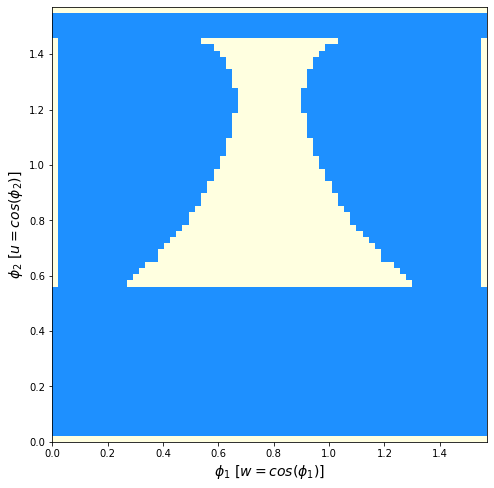

In [6]:
l0 = np.sqrt(0.22)#np.cos(0.342*np.pi)#lambda0

tic = time.perf_counter()
result_map = get_result_map_mosek(l0=l0 , N_it=70)
toc = time.perf_counter()
print('time: ',toc-tic)

fig, ax = plt.subplots(figsize=(8,8))
# using ListedColormap method from the colors package we can define a color map
colormap = colors.ListedColormap(["lightyellow","dodgerblue"])
# handing this problem over to 
plt.imshow(result_map,
             cmap=colormap,  extent=[0,np.pi/2,0,np.pi/2], origin='lower')
plt.xlabel("$\phi_1 \ [w=cos(\phi_1)]$",
             size = 14)
plt.ylabel("$\phi_2 \ [u=cos(\phi_2)]$",
             size = 14)

plt.show()


(array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633]),
 [Text(0.0, 0, '0'),
  Text(0.39269908169872414, 0, '${\\pi/8}$'),
  Text(0.7853981633974483, 0, '${\\pi/4}$'),
  Text(1.1780972450961724, 0, '${3\\pi/8}$'),
  Text(1.5707963267948966, 0, '${\\pi/2}$')])

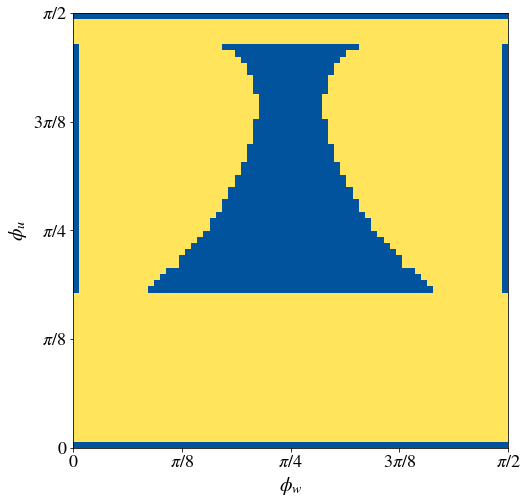

In [7]:
import matplotlib
import matplotlib.ticker as mtick
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'



matplotlib.rcParams['axes.titlepad'] = 10  # pad is in points...

fig, ax = plt.subplots(figsize=(8,8))

#ax.set_title("Nonlocal Region Map", size = 20)

colormap = colors.ListedColormap(["#00539cff", "#ffe45c"])

plt.imshow(result_map,origin='lower', extent=[0,np.pi/2,0,np.pi/2], cmap=colormap)



plt.xlabel("$\phi_w$", size = 20)
plt.ylabel("$\phi_u$", size = 20)


theta = np.linspace(0, np.pi/2, 5)
plt.xticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])

plt.yticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)


In [8]:
fig.savefig('nonlocality_22.pdf', bbox_inches='tight') 

# many plots $\lambda^2$

In [20]:
l0_2_list = np.linspace(0.01,0.49,9)
l0_2_list

array([0.01, 0.07, 0.13, 0.19, 0.25, 0.31, 0.37, 0.43, 0.49])

time:  31.66402845799996


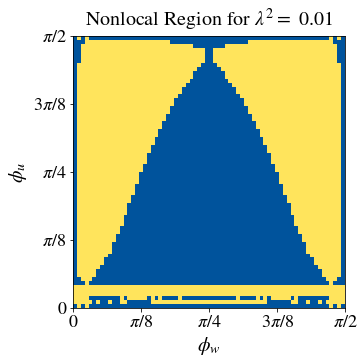

time:  29.563419374999967


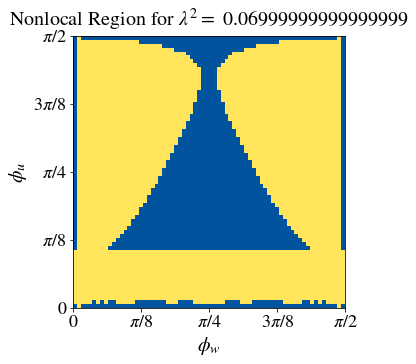

time:  29.551890749999984


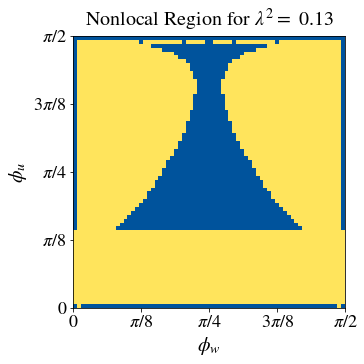

time:  29.387369207999996


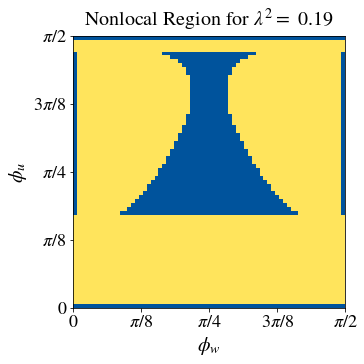

time:  30.50247412500005


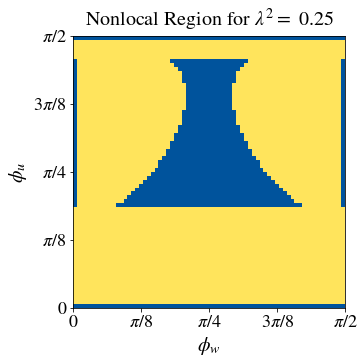

time:  30.57924808300004


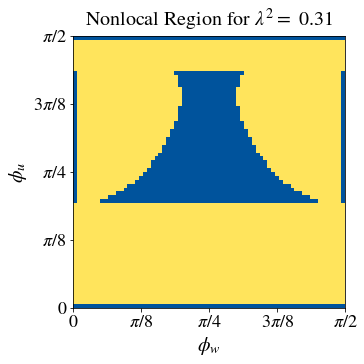

time:  31.33719704200007


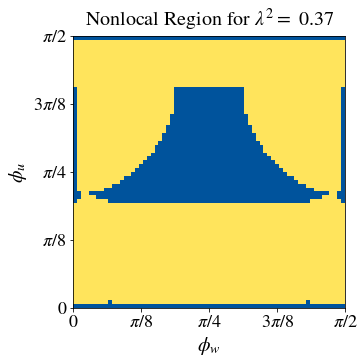

time:  32.08564425000009


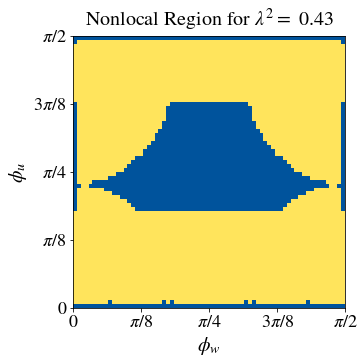

time:  31.54370787500011


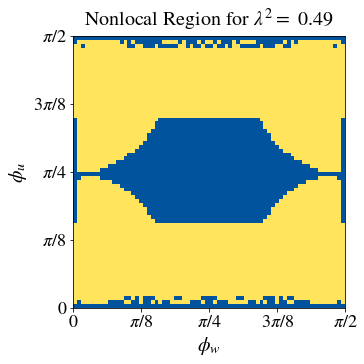

In [23]:
import matplotlib
import matplotlib.ticker as mtick
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'





for l02 in l0_2_list:

    l0 = np.sqrt(l02)

    tic = time.perf_counter()
    result_map = get_result_map_mosek(l0=l0 , N_it=70)
    toc = time.perf_counter()
    print('time: ',toc-tic)

    matplotlib.rcParams['axes.titlepad'] = 10  # pad is in points...

    fig, ax = plt.subplots(figsize=(5,5))

  
    ax.set_title("Nonlocal Region for $\lambda^2 =$ "+str(l02), size = 20)

    colormap = colors.ListedColormap(["#00539cff", "#ffe45c"])

    plt.imshow(result_map,origin='lower', extent=[0,np.pi/2,0,np.pi/2], cmap=colormap)



    plt.xlabel("$\phi_w$", size = 20)
    plt.ylabel("$\phi_u$", size = 20)


    theta = np.linspace(0, np.pi/2, 5)
    plt.xticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])

    plt.yticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])

    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)


    plt.show()
